# Predictions with Long Short Term Memory (LSTM)

In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

from scripts.data import deutsches_wetterdienst

In [5]:
df = deutsches_wetterdienst('/Users/stewarta/Documents/DATA/htsensor/produkt_tu_stunde_19510101_20171231_00662.txt', start=2010, end=2016)
df.head()

,Temp,Humi
datetime,,
2010-01-01 00:00:00,-1.8,89.0
2010-01-01 01:00:00,-1.8,88.0
2010-01-01 02:00:00,-1.8,89.0
2010-01-01 03:00:00,-1.8,88.0
2010-01-01 04:00:00,-2.1,91.0


## Experiment with the Model Parameters

### Change the Frequency

Here are a few frequency values that you can experiment with:

* YearEnd: 'A' calendar year end
* QuarterEnd: 'Q' calendar quarter end
* MonthEnd: 'M' calendar month end
* Week: 'W' one week, optionally anchored on a day of the week
* Day: 'D' one absolute day
* Hour: 'H' one hour

Learn more about datetime offsets in the pandas documentation:

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html?highlight=datetime


### Change the Feature

You can choose from Temperature (Temp) or Humidity (Humi). 

Experiment with the parameters, and discover which ones give you the best performing Neural Network models.

In [6]:
# change the frequency
timestep = 'D'

# change the feature
feature = 'Humi'
df = df.resample(timestep).mean().ffill()
df.head()

,Temp,Humi
datetime,,
2010-01-01,-1.991667,87.375000
2010-01-02,-3.612500,92.000000
2010-01-03,-4.604167,91.500000
2010-01-04,-5.462500,84.375000
2010-01-05,-5.525000,82.166667


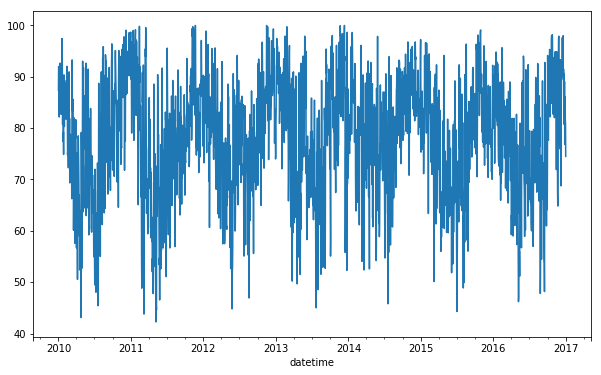

In [7]:
# df = df.sort_index()
plt.figure(figsize=(10, 6))
df[feature].plot();

In [8]:
split_date = pd.Timestamp('2016-01-01')

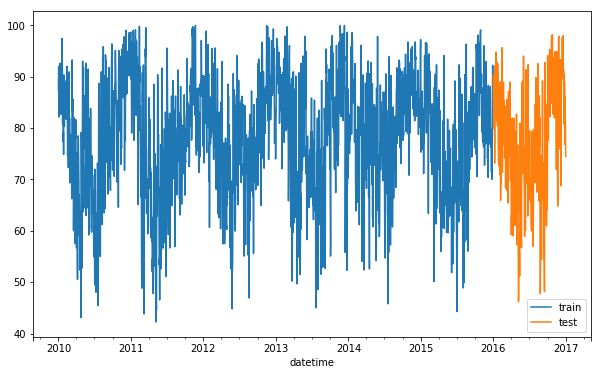

In [9]:
s =  df[feature]
train = s.loc[:split_date]
test = s.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [11]:
# scale train and test data to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_sc = scaler.fit_transform(train.values.reshape(-1,1))
test_sc = scaler.transform(test.values.reshape(-1,1))

In [12]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

## NN

In [120]:
nn_model = Sequential()
nn_model.add(Dense(12, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/100
1732/1732 [==============================] - 7s 4ms/step - loss: 0.0112
Epoch 2/100
1732/1732 [==============================] - 8s 5ms/step - loss: 0.0063
Epoch 3/100
1732/1732 [==============================] - 8s 5ms/step - loss: 0.0063A: 0s - loss: 0.006
Epoch 4/100
1732/1732 [==============================] - 11s 7ms/step - loss: 0.0063
Epoch 5/100
1732/1732 [==============================] - 8s 5ms/step - loss: 0.0062
Epoch 6/100
1732/1732 [==============================] - 8s 4ms/step - loss: 0.0062
Epoch 7/100
1732/1732 [==============================] - 9s 5ms/step - loss: 0.0061
Epoch 8/100
1732/1732 [==============================] - 8s 5ms/step - loss: 0.0061
Epoch 9/100
1732/1732 [==============================] - 9s 5ms/step - loss: 0.0061
Epoch 10/100
1732/1732 [==============================] - 8s 5ms/step - loss: 0.0061
Epoch 11/100
1732/1732 [==============================] - 9s 5ms/step - loss: 0.0061
Epoch 12/100
1732/1732 [==============================

In [121]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.897
The R2 score on the Test set is:	0.789


## LSTM

In [13]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

/Users/stewarta/repos/iot-htsensor/iot-htsensor-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/stewarta/repos/iot-htsensor/iot-htsensor-env/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/Users/stewarta/repos/iot-htsensor/iot-htsensor-env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/stewarta/repos/iot-htsensor/iot-htsensor-env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [14]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (2191, 1, 1)
Test shape:  (365, 1, 1)


In [15]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
2191/2191 [==============================] - 7s 3ms/step - loss: 0.1005
Epoch 2/100
2191/2191 [==============================] - 6s 3ms/step - loss: 0.0802
Epoch 3/100
2191/2191 [==============================] - 6s 3ms/step - loss: 0.0801
Epoch 4/100
2191/2191 [==============================] - 6s 3ms/step - loss: 0.0801
Epoch 5/100
2191/2191 [==============================] - 6s 3ms/step - loss: 0.0801
Epoch 6/100
2191/2191 [==============================] - 6s 3ms/step - loss: 0.0801
Epoch 7/100
2191/2191 [==============================] - 6s 3ms/step - loss: 0.0801
Epoch 8/100
2191/2191 [==============================] - 6s 3ms/step - loss: 0.0801
Epoch 00008: early stopping


In [16]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.479
The R2 score on the Test set is:	0.494


In [22]:
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
print('LSTM: %f'%lstm_test_mse)

365/365 [==============================] - 0s 1ms/step
LSTM: 0.076687


In [23]:
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

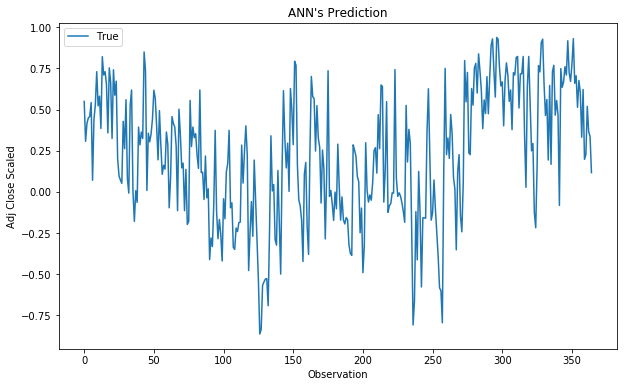

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.title("ANN's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

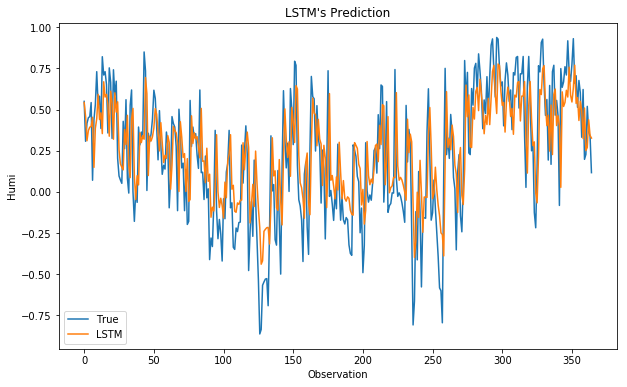

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel(feature)
plt.legend()
plt.show();